In [ ]:
# DeCET application to prostate cancer data

In [1]:
import numpy as np
import torch
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.legend import Legend

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '5_11_20' # Change this to today's date for output names.

#input_dir = '../tensor_input/' # directory where the HOSVD files can be found
input_dir = '../DeCET_prostate_cancer/'
file_prefix = 'DeCET_PCa_final'
output_dir = '../' # directory to write output

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 39
n_as = 3
n_loc = len(index)
fp.close()

sample_proj = np.zeros((n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1]] = projections[k]
assay_name = ['H3K27ac', 'H3K27me3', 'AR']

117 117


In [3]:
# Read in the SRA table for the prostate cancer dataset.
# This data can be found at GSE120738
df_meta_data = pd.read_csv(input_dir + 'SraRunTable-PCa.txt')
df_meta_data

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,case/control,Center Name,chip_antibody,...,LibrarySelection,LibrarySource,Organism,patient_id,Platform,ReleaseDate,Sample Name,source_name,SRA Study,tissue
0,SRR7949074,ChIP-Seq,65,1600330810,PRJNA494344,SAMN10160663,781536525,Case,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P223T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409642,primary prostate cancer,SRP163171,primary prostate cancer
1,SRR7949075,ChIP-Seq,65,1464614905,PRJNA494344,SAMN10160662,727424782,Case,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P227T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409643,primary prostate cancer,SRP163171,primary prostate cancer
2,SRR7949076,ChIP-Seq,65,1455590110,PRJNA494344,SAMN10160727,722122862,Control,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P228T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409644,primary prostate cancer,SRP163171,primary prostate cancer
3,SRR7949077,ChIP-Seq,65,1306680700,PRJNA494344,SAMN10160726,638372799,Case,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P229T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409645,primary prostate cancer,SRP163171,primary prostate cancer
4,SRR7949078,ChIP-Seq,65,1655589520,PRJNA494344,SAMN10160725,766720924,Case,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P230T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409646,primary prostate cancer,SRP163171,primary prostate cancer
5,SRR7949079,ChIP-Seq,65,1565998070,PRJNA494344,SAMN10160724,768716023,Control,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P249T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409647,primary prostate cancer,SRP163171,primary prostate cancer
6,SRR7949080,ChIP-Seq,65,1418765075,PRJNA494344,SAMN10160723,696822213,Control,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P252T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409648,primary prostate cancer,SRP163171,primary prostate cancer
7,SRR7949081,ChIP-Seq,65,1434248270,PRJNA494344,SAMN10160722,685535106,Exclude,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P254T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409649,primary prostate cancer,SRP163171,primary prostate cancer
8,SRR7949082,ChIP-Seq,65,2584458175,PRJNA494344,SAMN10160721,1429934641,Case,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P255T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409650,primary prostate cancer,SRP163171,primary prostate cancer
9,SRR7949083,ChIP-Seq,65,1585871170,PRJNA494344,SAMN10160720,780120083,Control,GEO,"AR (Santa Cruz\, catalog# sc-816\, mix of 4 lo...",...,ChIP,GENOMIC,Homo sapiens,P257T,ILLUMINA,2018-10-04T00:00:00Z,GSM3409651,primary prostate cancer,SRP163171,primary prostate cancer


In [4]:
# Only include patients with data for H3K27ac, H3K4me3, and H3K4me1.
# Only include patients with a label for recurrence (case or control).
# Remove patients for which the data files from GEO do not match the 
# data summary provided in the publishing study.
pt_dic = {}
for pt in df_meta_data['patient_id'].unique():
    pt_dic[pt] = df_meta_data[df_meta_data['patient_id'] == pt]['chip_antibody'].values
    
    
chip_assays = ['H3K27ac (Active Motif\\, catalog# 39133\\, lot# 31814008)',
                'H3K4me3 (Abcam\\, catalog# Ab8580\\, lot# GR240214-2)',
                'H3K27me3 (Active Motif\\, catalog# 39155\\, lot# 31814017)',
'AR (Santa Cruz\\, catalog# sc-816\\, mix of 4 lot#s B2114\\, H2914\\, A0515\\, J0614)']

exclude_patient_list = ['P695T', 'P680T', 'P555T',
                       'P544T', 'P355T', 'P294T', 'P265T',
                       'P254T', 'P291T']


N = 0
n_case = 0
n_control = 0
memory = 0
pt_list = []
for pt in pt_dic:
    if(pt in exclude_patient_list):
        continue
    if(chip_assays[0] in pt_dic[pt] and chip_assays[1] in pt_dic[pt] and chip_assays[2] in pt_dic[pt] and chip_assays[3] in pt_dic[pt]):
        pt_list.append(pt)
        N += 1
        if(df_meta_data[df_meta_data['patient_id'] == pt]['case/control'].values.all() == 'Case'):
            n_case += 1
        elif(df_meta_data[df_meta_data['patient_id'] == pt]['case/control'].values.all() == 'Control'):
            n_control += 1
            
print(N, n_case, n_control)

39 22 17


In [5]:
# Get SRA file list

condition = {}
i = 0
for pt in pt_list:
    if(df_meta_data.loc[(df_meta_data['patient_id'] == pt)]['case/control'].values[0] == 'Exclude'):
        continue
    if(df_meta_data.loc[(df_meta_data['patient_id'] == pt)]['case/control'].values[0] == 'Case'):
        condition[i] = 'Case'
    elif(df_meta_data.loc[(df_meta_data['patient_id'] == pt)]['case/control'].values[0] == 'Control'):
        condition[i] = 'Control'
    i += 1
    
condition_color = []
for i in range(n_pt):
    if(condition[i] == 'Case'):
        condition_color.append((0,0,1,1))
    else:
        condition_color.append((1,0,0,1))

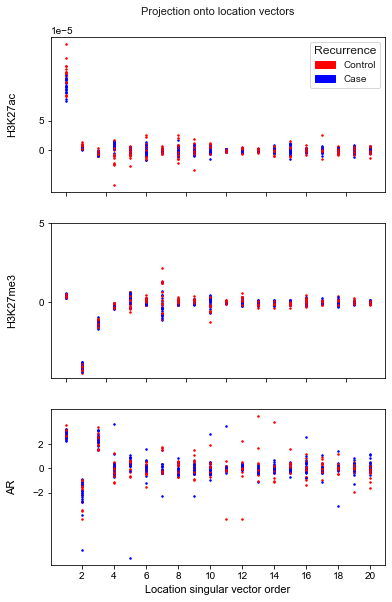

In [6]:
# Stacked projections for the prostate cancer.
# Samples are colored by recurrence status.
fig = plt.figure(figsize=(6,20))
legend_recurrence = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0)], ["Control", "Case"])]
n_proj = 20

ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(611+k))
    for i in range(n_pt):
        ax[k].plot(sample_proj[i, assay][0:n_proj],'.', markersize=3, c=condition_color[i])
        
    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)
        ax[k].legend(handles=legend_recurrence,
                     frameon=True, fontsize=10,
                     title='Recurrence', title_fontsize=12)        
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    ax[k].get_yaxis().set_label_coords(-0.1,0.5)
    if(k == 0):
        plt.yticks([0,5*10**-5])
    elif(k == 1):
        plt.yticks([0,5*10**-5])
    else:
        plt.yticks([-2*10**-5,0,2*10**-5])
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

In [7]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Select the location vectors to use for clustering.
use = []
assay_std = [[np.std(sample_proj[:,k,l]) for l in range(n_loc)] for k in range(n_as)]
for k in range(n_as):
    print(np.argsort(assay_std[k])[-5:])
    for l in range(1, 6):
        if(np.argsort(assay_std[k])[-l] not in use):
            use.append(np.argsort(assay_std[k])[-l])
print(np.sort(use))

tissue_sample = np.copy(sample_proj[:,:,use])
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)
    
print(tissue_sample.shape)
D = np.zeros((n_pt, n_pt))
for i in range(n_pt):
    for j in range(n_pt):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

[8 7 5 3 0]
[53 37 41 23  6]
[11 12 10  1  4]
[ 0  1  3  4  5  6  7  8 10 11 12 23 37 41 53]
(39, 3, 15)
(39, 3, 15)


In [8]:
# Get color labels for the assay and location vector to
# use in the clustering heatmap
assay_colors = [(51/255,70/255,0,1.0), (204/255,20/255,204/255,1.0), (104/255,20/255,10/255,1.0)]
# Reorder the assays to group more correlated assays
# together for visualization.
reorder_assays = [0,2,1]
index_order = []
col_loc_color = []
single_col_color = []
col_assay = []
            
for l in range(len(use)):
    if(l % 2 == 0):
        single_col_color.append('k')
    else:
        single_col_color.append((0.5,0.5,0.5,1))
    for k in range(n_as):
        index_order.append(len(use)*k + l)
        col_assay.append(assay_colors[reorder_assays[k]])
    if(l % 2 == 0):
        for k in range(n_as):
            col_loc_color.append('k')
    else:
        for k in range(n_as):
            col_loc_color.append((0.5,0.5,0.5,1))
    
col_index = []
for i in range(len(use)):
    col_index.append(np.sort(use)[i] + 1)
    col_index.append(np.sort(use)[i] + 1)
    col_index.append(np.sort(use)[i] + 1)

In [9]:
# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Get patient labels for the three clusters.
clust_labels = hc.cut_tree(linkage, n_clusters=3)
print(np.where(clust_labels == [0])[0])
print(np.where(clust_labels == [1])[0])
print(np.where(clust_labels == [2])[0])
clust1 = np.where(clust_labels == [0])[0]
clust2 = np.where(clust_labels == [1])[0]
clust3 = np.where(clust_labels == [2])[0]

# Color the patient according to the cluster labels.
pt_clust_color = []
for i in range(n_pt):
    if(i in clust1):
        pt_clust_color.append((1.0,0.6,0.2,1.0))
    elif(i in clust2):
        pt_clust_color.append((0.0,0.25,0.4,1.0))
    elif(i in clust3):
        pt_clust_color.append((0.0,0.8,0.0,1.0))
        

[ 0  1  2  3  5  7  8 10 11 12 21 24 29 36]
[ 4  6  9 13 14 17 19 20 22 26 30 31 32 33 34 37]
[15 16 18 23 25 27 28 35 38]


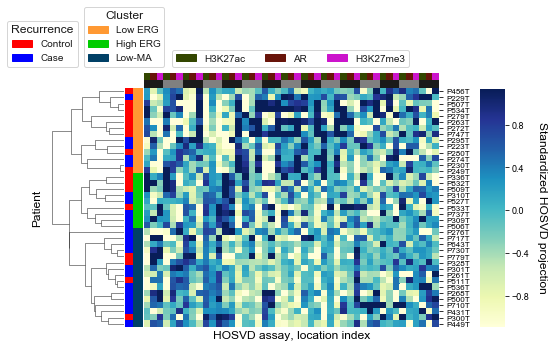

In [10]:
# Figure 3C (unsupervised hierarchical clustering of tissue samples)
legend_recurrence = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0)], ["Control", "Case"])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]
legend_clust = [mpatches.Patch(color=c, label=l) for c,l in zip([(1.0,0.6,0.2,1.0), (0.0,0.8,0.0,1.0), (0.0,0.25,0.4,1.0)],
                                                                ['Low ERG', 'High ERG', 'Low-MA'])]

# Flatten the assay-location data into a vector that
# can be used for visualization.
full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj,axis=0))

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=[condition_color, pt_clust_color],
                       col_colors=[col_assay, col_loc_color],
                       xticklabels=[] , yticklabels=pt_list, figsize=(7,5.8),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([0.98,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=9)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.48,1.07), handles=legend_recurrence,
                       frameon=True, fontsize=10,
                       title='Recurrence', title_fontsize=12)
g.cax.legend(loc='lower left', bbox_to_anchor=(-12.4,1.07), handles=legend_assay,
                       frameon=True, fontsize=10, ncol=3)

g.ax_row_dendrogram.legend(loc='lower left', bbox_to_anchor=(0.4,1.07), handles=legend_clust,
                           frameon=True, fontsize=10, ncol=1,
                           title='Cluster', title_fontsize=12)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Patient', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.38,0.5)
g.savefig(output_dir + 'figures/figure3_panels/' + file_prefix + '_panelC_clustering_figure_' +
          date + '.pdf', format='pdf', transparent=True, bbox_inches='tight')

In [11]:
# Open the gene expression table for this dataset.
# The data can be obtained at GSE120741.
dt_rna = pd.read_csv(input_dir + 'GSE120741_Porto_ge_table.txt', header=1, index_col=0,
                     skiprows=0, delimiter='\t')

In [12]:
# Select a cluster and perform differential expression
# between the patients within and outside the cluster.
sclust = clust1

# Get the patient labels for the two groups.
clust1_rna_pts = []
for i in sclust:
    if(pt_list[i] in dt_rna.columns.values):
        clust1_rna_pts.append(pt_list[i])
clust2_rna_pts = []
for i in range(n_pt):
    if(i not in sclust):
        if(pt_list[i] in dt_rna.columns.values):
            clust2_rna_pts.append(pt_list[i])
print(clust1_rna_pts)
print(clust2_rna_pts)

['P223T', 'P229T', 'P230T', 'P263T', 'P272T', 'P274T', 'P279T', 'P456T', 'P507T', 'P534T', 'P747T']
['P261T', 'P268T', 'P276T', 'P300T', 'P301T', 'P309T', 'P310T', 'P431T', 'P449T', 'P500T', 'P506T', 'P509T', 'P511T', 'P527T', 'P533T', 'P536T', 'P643T', 'P710T', 'P717T', 'P730T', 'P737T', 'P779T', 'P832T']


In [13]:
# Perform differential expression using the t-test.
t_test_results = np.zeros((dt_rna.shape[0],2))
for j in range(dt_rna.shape[0]):
    if(j % 1000 == 0):
        print(j)
    t_test_results[j,0] = scipy.stats.ttest_ind(dt_rna.loc[:,clust1_rna_pts].values[j,:],
                                                dt_rna.loc[:,clust2_rna_pts].values[j,:],
                                                equal_var=False)[0]
    
    t_test_results[j,1] = scipy.stats.ttest_ind(dt_rna.loc[:,clust1_rna_pts].values[j,:],
                                                dt_rna.loc[:,clust2_rna_pts].values[j,:],
                                                equal_var=False)[1]    

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [14]:
# Get the differentially expressed genes
DE_l = []
DE_h = []
for j in np.argsort(t_test_results[:,1]):
    if(t_test_results[j,1] >= 0.001):
        break
    if(t_test_results[j,0] < 0.0):
        DE_l.append(j)
    else:
        DE_h.append(j)

In [15]:
# Print the genes differentailly expressed higher in the
# selected cluster
for gene in dt_rna.index.values[DE_h]:
    print(gene)

TFF3
MPC2
PTPRM
FXYD3
AZGP1
TMEM9B
CYP2R1
B3GNT1
CHRNA2
KAZALD1
CTBS
TIMM22
PNKD
PCMT1
JAGN1
FAM189A2
NDUFC2
BNIP3
EMC8
MINOS1
CTSF
ADPRM
MARC1
MAPK4
ALDH7A1
CAMKK2
SLC25A4
RAB27A
CCDC127
SMS
MESP1
DTNB
ALOX15B
MAGEF1
MARC2


In [16]:
# Print the genes differentailly expressed lower in the
# selected cluster
for gene in dt_rna.index.values[DE_l]:
    print(gene)

GDA
ARHGDIB
ATP11A
WDR66
SEL1L3
LAMC2
KCNS3
UBASH3B
IKZF1
AMPD3
ANKRD34B
SH3RF1
COL2A1
PAX1
NFE2L3
PTK6
CDR2L
KIAA0087
ALOX15
TBC1D22B
ERG
ANKRD6
TDO2
CC2D2A
GPR110
RSPH4A
AGR3
AMMECR1
FZD8
MFSD4
FRK
PARG
ZNF750
MSI2
GNPTAB
FAM19A5
BCOR
ATP2A3
OGDHL
MYO6
H2AFY2
AKAP5
ENC1
PDE3B
NCOA3
SLITRK5
SLC12A1
ADARB2
